In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# DATA LOADING

In [2]:
train = pd.read_csv("course_project_train.csv")
test = pd.read_csv("course_project_test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

display(train.head())

Train shape: (7500, 17)
Test shape: (2500, 16)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


# EDA
# Target distribution

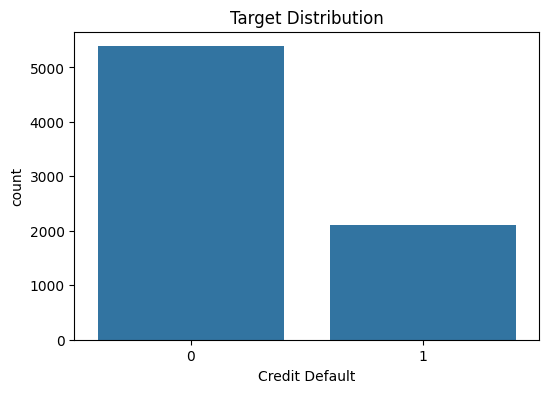

Credit Default
0    0.718267
1    0.281733
Name: proportion, dtype: float64


In [3]:
plt.figure(figsize=(6,4))
sns.countplot(x='Credit Default', data=train)
plt.title("Target Distribution")
plt.show()

print(train["Credit Default"].value_counts(normalize=True))

# Missing values

Missing values:
Months since last delinquent    4081
Annual Income                   1557
Credit Score                    1557
Years in current job             371
Bankruptcies                      14
dtype: int64


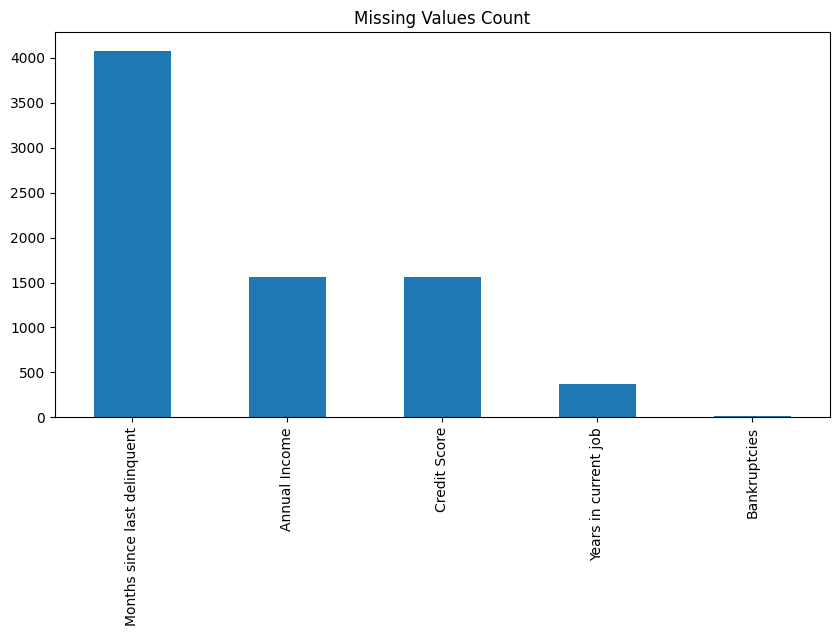

In [4]:
missing = train.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("Missing values:")
print(missing)

plt.figure(figsize=(10,5))
missing.plot(kind='bar')
plt.title("Missing Values Count")
plt.show()

# Numerical Features Analysis

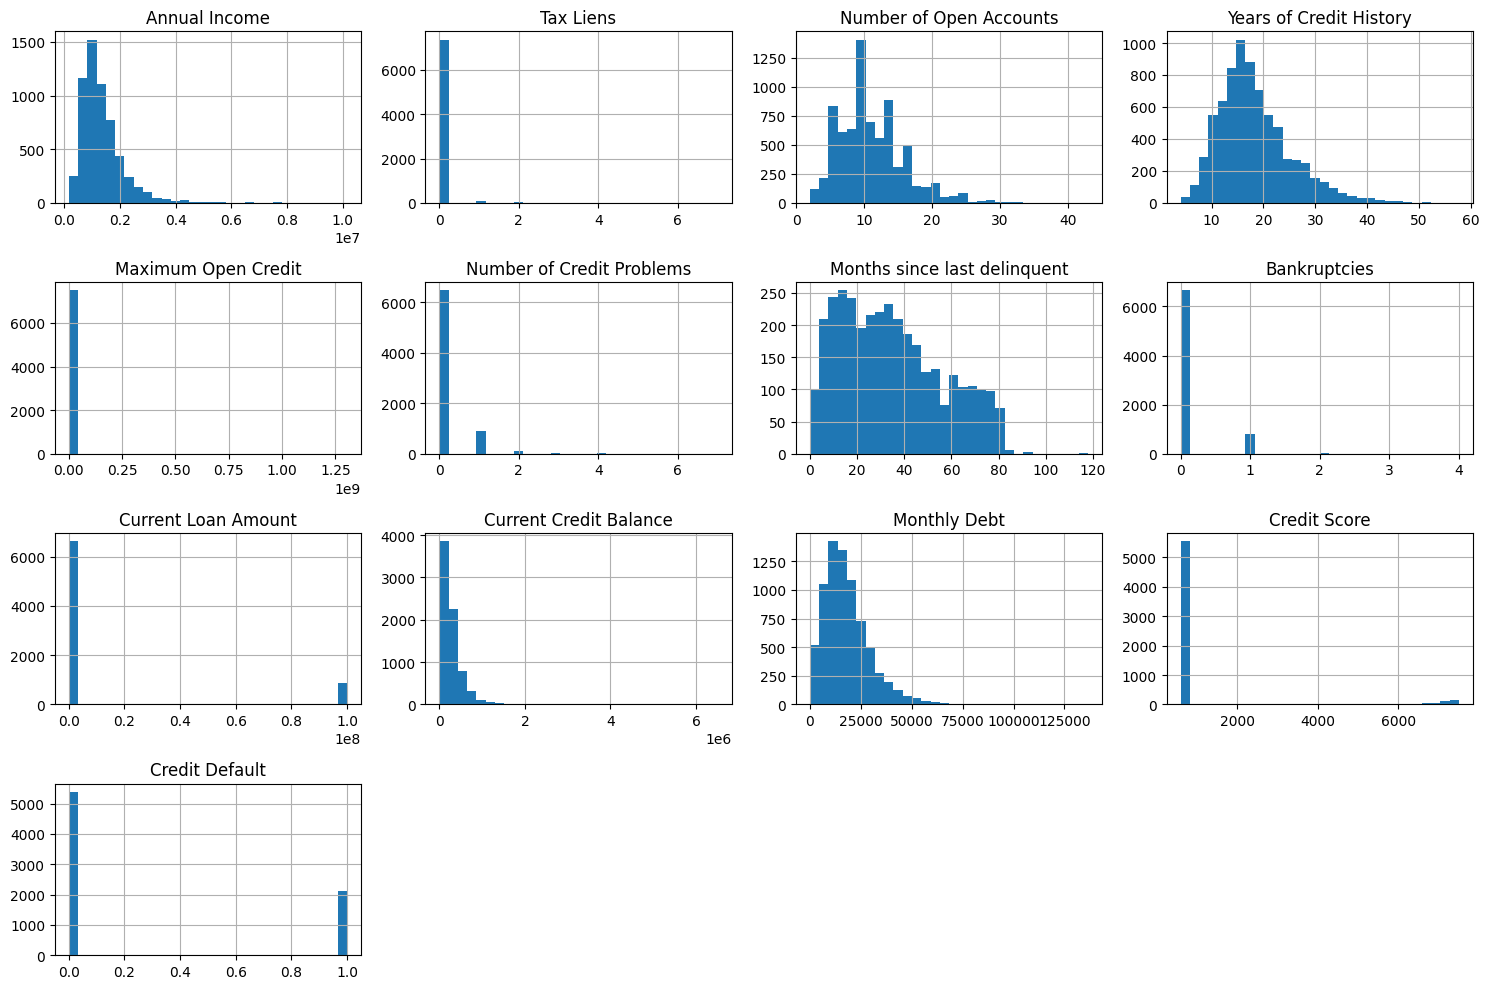

In [5]:
num_cols = train.select_dtypes(include=['int64','float64']).columns

train[num_cols].hist(figsize=(15,10), bins=30)
plt.tight_layout()
plt.show()

# Correlation 

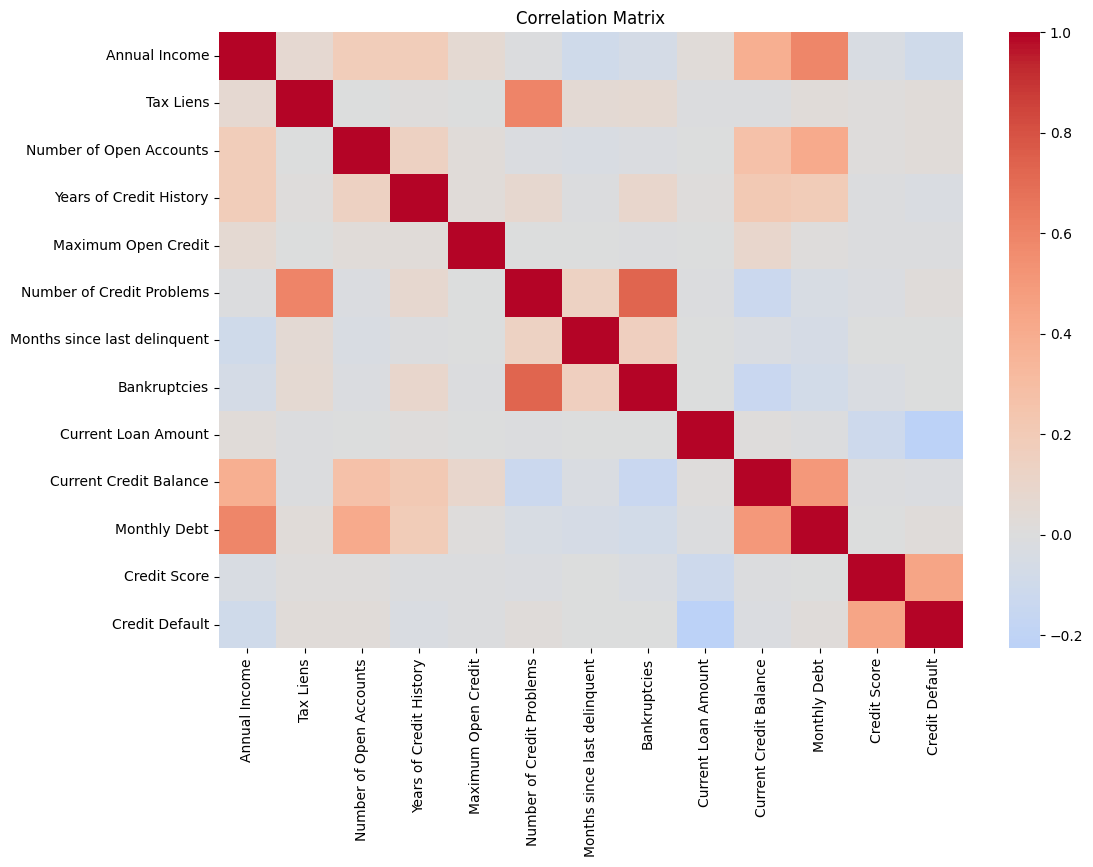

Correlation with target:
Credit Default                  1.000000
Credit Score                    0.442050
Number of Open Accounts         0.028884
Tax Liens                       0.024368
Number of Credit Problems       0.020088
Monthly Debt                    0.018480
Months since last delinquent    0.002598
Bankruptcies                    0.001648
Maximum Open Credit            -0.014275
Current Credit Balance         -0.019522
Years of Credit History        -0.020567
Annual Income                  -0.101375
Current Loan Amount            -0.226522
Name: Credit Default, dtype: float64


In [6]:
plt.figure(figsize=(12,8))
corr = train[num_cols].corr()

sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

print("Correlation with target:")
print(corr["Credit Default"].sort_values(ascending=False))

# Categorical Features Analysis

Categorical features:
Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='str')


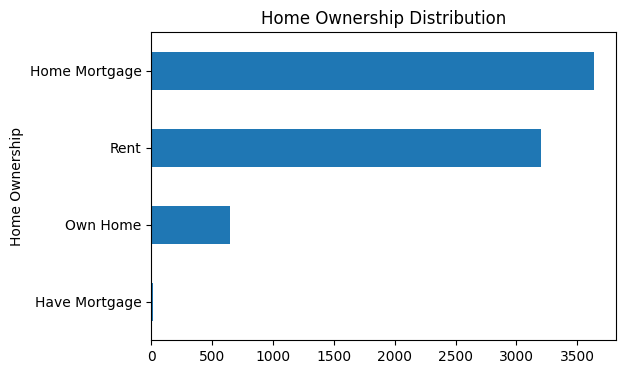

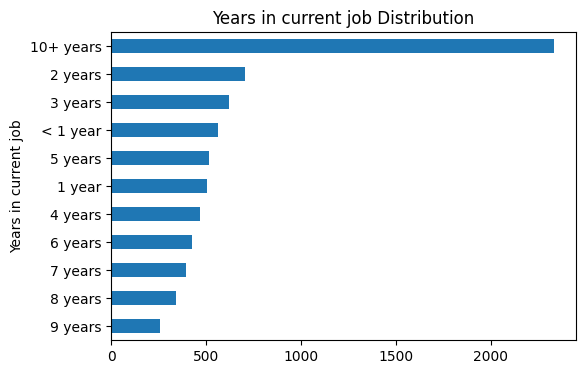

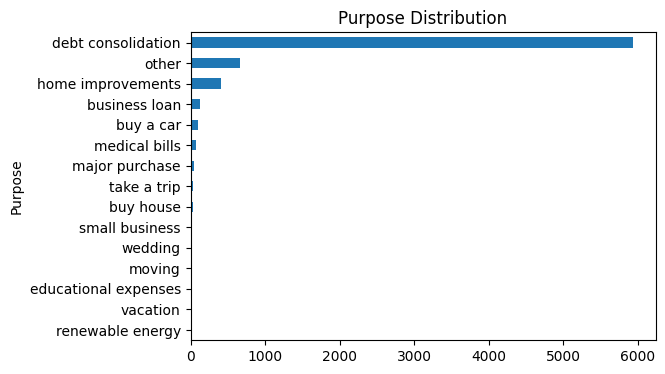

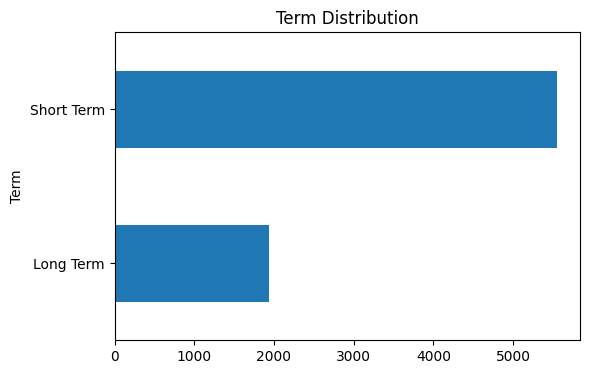

In [12]:
cat_cols = train.select_dtypes(include=['object', 'string']).columns

print("Categorical features:")
print(cat_cols)

for col in cat_cols:
    plt.figure(figsize=(6,4))
    train[col].value_counts().plot(kind='barh')
    plt.title(f"{col} Distribution")
    plt.gca().invert_yaxis()
    plt.show()

# Train / Validation Split

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, valid_idx in split.split(train, train["Credit Default"]):
    strat_train = train.loc[train_idx]
    strat_valid = train.loc[valid_idx]

X_train = strat_train.drop("Credit Default", axis=1)
y_train = strat_train["Credit Default"]

X_valid = strat_valid.drop("Credit Default", axis=1)
y_valid = strat_valid["Credit Default"]

# DATA PREPROCESSING

In [13]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'string']).columns

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# LOGISTIC REGRESSION (BASELINE)

In [14]:
log_model = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=3000,
        random_state=42
    ))
])

log_model.fit(X_train, y_train)

log_probs = log_model.predict_proba(X_valid)[:,1]
log_preds = log_model.predict(X_valid)

log_f1 = f1_score(y_valid, log_preds)
log_auc = roc_auc_score(y_valid, log_probs)
log_gini = 2 * log_auc - 1

print("Logistic F1:", log_f1)
print("Logistic ROC-AUC:", log_auc)
print("Logistic Gini:", log_gini)

Logistic F1: 0.5166498486377397
Logistic ROC-AUC: 0.7540010228921507
Logistic Gini: 0.5080020457843013


# DECISION TREE

In [15]:
dt_model = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(
        max_depth=6,
        class_weight="balanced",
        random_state=42
    ))
])

dt_model.fit(X_train, y_train)

dt_probs = dt_model.predict_proba(X_valid)[:,1]
dt_preds = dt_model.predict(X_valid)

dt_f1 = f1_score(y_valid, dt_preds)
dt_auc = roc_auc_score(y_valid, dt_probs)
dt_gini = 2 * dt_auc - 1

print("Decision Tree F1:", dt_f1)
print("Decision Tree ROC-AUC:", dt_auc)
print("Decision Tree Gini:", dt_gini)

Decision Tree F1: 0.5251282051282051
Decision Tree ROC-AUC: 0.7396805327819375
Decision Tree Gini: 0.4793610655638749


# Random Forest 

In [16]:
rf_model = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        class_weight="balanced",
        random_state=42
    ))
])

param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [4, 6, 8]
}

grid = GridSearchCV(
    rf_model,
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_rf = grid.best_estimator_

rf_probs = best_rf.predict_proba(X_valid)[:,1]
rf_preds = best_rf.predict(X_valid)

rf_f1 = f1_score(y_valid, rf_preds)
rf_auc = roc_auc_score(y_valid, rf_probs)
rf_gini = 2 * rf_auc - 1

print("Random Forest F1:", rf_f1)
print("Random Forest ROC-AUC:", rf_auc)
print("Random Forest Gini:", rf_gini)

Random Forest F1: 0.5308775731310943
Random Forest ROC-AUC: 0.7617232001158986
Random Forest Gini: 0.5234464002317971



# XGBOOST

In [17]:
xgb_model = Pipeline([
    ("prep", preprocessor),
    ("model", XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        scale_pos_weight=1,
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False
    ))
])

xgb_model.fit(X_train, y_train)

xgb_probs = xgb_model.predict_proba(X_valid)[:,1]
xgb_preds = xgb_model.predict(X_valid)

xgb_f1 = f1_score(y_valid, xgb_preds)
xgb_auc = roc_auc_score(y_valid, xgb_probs)
xgb_gini = 2 * xgb_auc - 1

print("XGBoost F1:", xgb_f1)
print("XGBoost ROC-AUC:", xgb_auc)
print("XGBoost Gini:", xgb_gini)

/opt/anaconda3/envs/credit_env/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [19:02:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1: 0.44408427876823336
XGBoost ROC-AUC: 0.7436645440557015
XGBoost Gini: 0.48732908811140296


# MODEL COMPARISON

In [18]:
results = pd.DataFrame({
    "Model": ["Logistic", "Decision Tree", "Random Forest", "XGBoost"],
    "F1": [log_f1, dt_f1, rf_f1, xgb_f1],
    "ROC-AUC": [log_auc, dt_auc, rf_auc, xgb_auc],
    "Gini": [log_gini, dt_gini, rf_gini, xgb_gini]
})

print(results.sort_values(by="F1", ascending=False))

           Model        F1   ROC-AUC      Gini
2  Random Forest  0.530878  0.761723  0.523446
1  Decision Tree  0.525128  0.739681  0.479361
0       Logistic  0.516650  0.754001  0.508002
3        XGBoost  0.444084  0.743665  0.487329


# CONFUSION MATRIX 

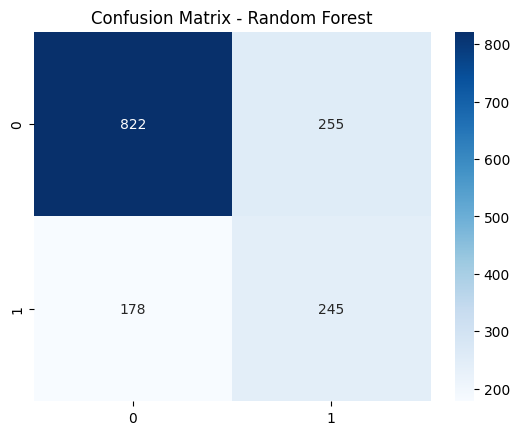

In [19]:
sns.heatmap(confusion_matrix(y_valid, rf_preds),
            annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# FINAL PREDICTION AND SUBMISSION


In [20]:
final_model = best_rf

final_probs = final_model.predict_proba(test)[:,1]
final_preds = (final_probs >= 0.5).astype(int)

submission = pd.DataFrame({
    "Id": test.index,
    "Credit Default": final_preds
})

submission.to_csv("submission.csv", index=False)

print("Submission saved successfully.")

Submission saved successfully.
